In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20
import seaborn as sns
from fastaUtils.profiles import parse_profile,profile_data
from lbsNN import postprocess
from sklearn.decomposition import PCA
from umap import UMAP

tfk=tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

## Classes and helper functions

In [2]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

In [3]:
class AutoregressiveGenerate(tf.keras.Model):
  def __init__(self, model, name=''):
    super(AutoregressiveGenerate, self).__init__(name=name)
    self.model=tfk.models.clone_model(model)
    self.concat = tfkl.concatenate
    
  def call(self, input_tensor, training=False):
    x = self.model(input_tensor)
    x = tfd.OneHotCategorical(logits=x,dtype=tf.float32).sample()
    x = self.concat([input_tensor,x])
    return x

class AutoregressiveFit(tf.keras.Model):
  def __init__(self, model, name=''):
    super(AutoregressiveFit, self).__init__(name=name)
    self.model=tfk.models.clone_model(model)
    self.log_softmax = tf.nn.log_softmax
    
  def call(self, input_tensor, training=False):
    x = self.model(input_tensor)
    x = self.log_softmax(x)
    return x

def makeModelGenerate( cumwidth, makeCell ):
    In=tfkl.Input((cumwidth[1]))
    ar=AutoregressiveGenerate(makeCell(cumwidth[2]-cumwidth[1],name="col1_cell"),name="col1")(In)
    for idx in range(3,len(cumwidth)):
        ar=AutoregressiveGenerate(makeCell(cumwidth[idx]-cumwidth[idx-1],name="col{}_cell".format(idx-1)),name="col{}".format(idx-1))(ar)
    return tfk.models.Model(In,ar)

def makeModelFit( cumwidth, makeCell ):
    In0=tfkl.Input((cumwidth[-1]))
    
    l0=In0[:,0:cumwidth[1]]
    l0=AutoregressiveFit( makeCell(cumwidth[2]-cumwidth[1],name="col1_cell"), name="col1")(l0)
    for c in range(2,len(cumwidth)-1):
        l=In0[:,0:cumwidth[c]]
        l=AutoregressiveFit( makeCell(cumwidth[c+1]-cumwidth[c],name="col{}_cell".format(c)), name="col{}".format(c))(l)
        l0=tfkl.concatenate([l0,l])
    return tfk.models.Model(In0,l0)

lossFit=lambda y,yt:-tf.reduce_mean(tf.reduce_sum(tf.multiply(y,yt),axis=1))

In [4]:
def decodeSequences(sequences,mapping):
    N=len(mapping)
    decoded=[]
    offset=0
    for n in range(N):
        q=len(mapping[n])
        s=sequences[:,offset:offset+q]
        idx=np.argmax(s,axis=1)
        chars=[mapping[n][i] for i in idx]
        decoded.append(chars)
        offset+=q
    decoded=np.array(decoded,dtype='str').T
    sequences=[]
    for dec in decoded:
        sequences.append("".join(dec))
    return sequences

In [5]:
def getDCAParams( cumwidth, model ):
    W=np.zeros((cumwidth[-1],cumwidth[-1]))
    B=np.zeros((cumwidth[-1]))
    offset=cumwidth[1]
    for layer in model.layers:
        if layer.name[:3]=="col":
            w,b=layer.get_weights()
            W[0:w.shape[0],offset:offset+w.shape[1]]=w
            B[offset:offset+w.shape[1]]=b
            offset+=w.shape[1]
    return B,W

## Dataset and settings

In [7]:
dataset="datasets/jdm_A"
outbasename="jdm_A_linear"

x=np.load("{dataset}.npy".format(dataset=dataset)).astype(float) # dataset
cumwidth=profile_data(parse_profile("{dataset}.profile".format(dataset=dataset))).cumulative

np.random.shuffle(x)
x=x[:10000]
Y=x[:,cumwidth[1]:]

epochs=5000
comparetodata=None
Ngen=10000
bs=1024 # batch size

if comparetodata is not None:
    xc=np.load(comparetodata).astype(float)

alphabet=list("-ACDEFGHIKLMNPQRSTVWY")

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlystopping = EarlyStopping(monitor='loss', patience=100, verbose=0, mode='min')
checkpoint=ModelCheckpoint("checkpoints/{}_weights".format(outbasename), monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
reduce_lr=ReduceLROnPlateau(factor=0.2,patience=20,monitor='loss')
lr_finder = LRFinder(min_lr=1e-6, max_lr=0.3,reload_weights=False)

In [8]:
from tensorflow.keras.regularizers import l2

def makeCell( outsize, name ):
    sequential=tfk.models.Sequential(name=name)
    sequential.add( tfkl.Dense(outsize,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='linear'))
    return sequential

## Models

In [9]:
generator=makeModelGenerate(cumwidth,makeCell)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
col1 (AutoregressiveGenerate (None, 20)                104       
_________________________________________________________________
col2 (AutoregressiveGenerate (None, 26)                126       
_________________________________________________________________
col3 (AutoregressiveGenerate (None, 44)                486       
_________________________________________________________________
col4 (AutoregressiveGenerate (None, 63)                855       
_________________________________________________________________
col5 (AutoregressiveGenerate (None, 72)                576       
_________________________________________________________________
col6 (AutoregressiveGenerate (None, 92)                1460  

In [10]:
autoencoder=makeModelFit(cumwidth,makeCell)
autoencoder.compile(optimizer='sgd', loss=lossFit)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 974)]        0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 7)            0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 20)           0           input_2[0][0]                    
__________________________________________________________________________________________________
col1 (AutoregressiveFit)        (None, 13)           104         tf.__operators__.getitem[0][0]   
____________________________________________________________________________________________

## Optimization of learning rate

Epoch 1/20
10/10 [==============================] - 6s 17ms/step - loss: 164.4565
Epoch 2/20
10/10 [==============================] - 0s 16ms/step - loss: 162.9502
Epoch 3/20
10/10 [==============================] - 0s 16ms/step - loss: 162.9527
Epoch 4/20
10/10 [==============================] - 0s 16ms/step - loss: 162.9028
Epoch 5/20
10/10 [==============================] - 0s 16ms/step - loss: 162.8661
Epoch 6/20
10/10 [==============================] - 0s 16ms/step - loss: 162.7797
Epoch 7/20
10/10 [==============================] - 0s 16ms/step - loss: 162.6409
Epoch 8/20
10/10 [==============================] - 0s 16ms/step - loss: 162.3166
Epoch 9/20
10/10 [==============================] - 0s 16ms/step - loss: 161.7438
Epoch 10/20
10/10 [==============================] - 0s 16ms/step - loss: 160.6964
Epoch 11/20
10/10 [==============================] - 0s 16ms/step - loss: 158.7208
Epoch 12/20
10/10 [==============================] - 0s 17ms/step - loss: 155.1408
Epoch 13/20
1

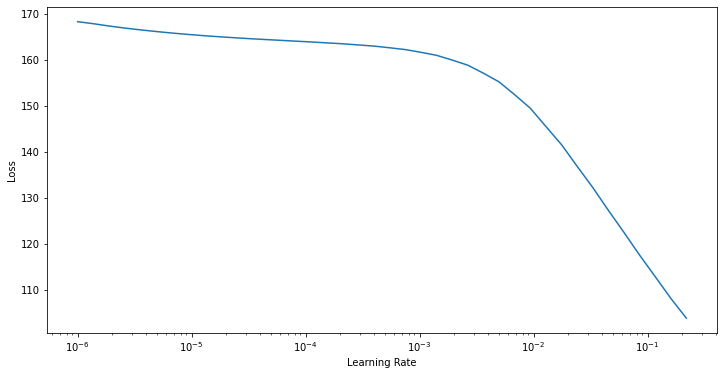

In [11]:
autoencoder.fit(x, Y, callbacks=[lr_finder,checkpoint], epochs=20, shuffle=True, batch_size=bs)

## Fitting

In [12]:
best_lr=1.e-1
optimizer=tf.keras.optimizers.SGD(lr=best_lr)
autoencoder.compile(optimizer=optimizer, loss=lossFit)

try:
    autoencoder.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

hist=autoencoder.fit(x,Y,epochs=epochs,shuffle=True,callbacks=[earlystopping,checkpoint,reduce_lr], batch_size=bs)

Epoch 1/5000
10/10 [==============================] - 6s 17ms/step - loss: 59.8935
Epoch 2/5000
10/10 [==============================] - 0s 15ms/step - loss: 57.0422
Epoch 3/5000
10/10 [==============================] - 0s 16ms/step - loss: 55.0044
Epoch 4/5000
10/10 [==============================] - 0s 15ms/step - loss: 53.5281
Epoch 5/5000
10/10 [==============================] - 0s 15ms/step - loss: 52.1708
Epoch 6/5000
10/10 [==============================] - 0s 16ms/step - loss: 51.4018
Epoch 7/5000
10/10 [==============================] - 0s 15ms/step - loss: 50.6329
Epoch 8/5000
10/10 [==============================] - 0s 16ms/step - loss: 49.9607
Epoch 9/5000
10/10 [==============================] - 0s 16ms/step - loss: 49.5229
Epoch 10/5000
10/10 [==============================] - 0s 16ms/step - loss: 48.9960
Epoch 11/5000
10/10 [==============================] - 0s 16ms/step - loss: 48.5155
Epoch 12/5000
10/10 [==============================] - 0s 15ms/step - loss: 48.0603
E

10/10 [==============================] - 0s 21ms/step - loss: 40.0600
Epoch 195/5000
10/10 [==============================] - 0s 22ms/step - loss: 39.9967
Epoch 196/5000
10/10 [==============================] - 0s 22ms/step - loss: 39.7876
Epoch 197/5000
10/10 [==============================] - 0s 22ms/step - loss: 39.8302
Epoch 198/5000
10/10 [==============================] - 0s 21ms/step - loss: 40.0547
Epoch 199/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.9583
Epoch 200/5000
10/10 [==============================] - 0s 22ms/step - loss: 39.9413
Epoch 201/5000
10/10 [==============================] - 0s 21ms/step - loss: 39.8938
Epoch 202/5000
10/10 [==============================] - 0s 22ms/step - loss: 40.0322
Epoch 203/5000
10/10 [==============================] - 0s 22ms/step - loss: 39.9936
Epoch 204/5000
10/10 [==============================] - 0s 21ms/step - loss: 40.0149
Epoch 205/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.

10/10 [==============================] - 0s 20ms/step - loss: 39.6074
Epoch 387/5000
10/10 [==============================] - 0s 16ms/step - loss: 39.7317
Epoch 388/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.8019
Epoch 389/5000
10/10 [==============================] - 0s 17ms/step - loss: 39.5578
Epoch 390/5000
10/10 [==============================] - 0s 17ms/step - loss: 39.5634
Epoch 391/5000
10/10 [==============================] - 0s 19ms/step - loss: 39.5840
Epoch 392/5000
10/10 [==============================] - 0s 16ms/step - loss: 39.6348
Epoch 393/5000
10/10 [==============================] - 0s 16ms/step - loss: 39.6650
Epoch 394/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.6596
Epoch 395/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.5396
Epoch 396/5000
10/10 [==============================] - 0s 18ms/step - loss: 39.5089
Epoch 397/5000
10/10 [==============================] - 0s 21ms/step - loss: 39.

10/10 [==============================] - 0s 15ms/step - loss: 39.5758
Epoch 579/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.6376
Epoch 580/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.4598
Epoch 581/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.7322
Epoch 582/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.5891
Epoch 583/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.3865
Epoch 584/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.5755
Epoch 585/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.4762
Epoch 586/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.5579
Epoch 587/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.5619
Epoch 588/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.6852
Epoch 589/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.

10/10 [==============================] - 0s 16ms/step - loss: 39.4712
Epoch 771/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.6086
Epoch 772/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.3045
Epoch 773/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.7189
Epoch 774/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.6167
Epoch 775/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.4102
Epoch 776/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.4604
Epoch 777/5000
10/10 [==============================] - 0s 16ms/step - loss: 39.3978
Epoch 778/5000
10/10 [==============================] - 0s 16ms/step - loss: 39.5843
Epoch 779/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.4255
Epoch 780/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.6142
Epoch 781/5000
10/10 [==============================] - 0s 15ms/step - loss: 39.

In [13]:
try:
    autoencoder.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

autoencoder.save_weights("checkpoints/{}_weights".format(outbasename))
generator.load_weights("checkpoints/{}_weights".format(outbasename))


Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980a50d90> and <__main__.AutoregressiveGenerate object at 0x7f79d039abe0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980a50d90> and <__main__.AutoregressiveGenerate object at 0x7f79d039abe0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d038e610> and <__main__.AutoregressiveGenerate object at 0x7f79d0389f10>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d038e610> and <__main__.AutoregressiveGenerate object at 0x7f79d0389f10>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d039abe0> and <__main__.AutoregressiveGenerate object at 0x7f79d038e850>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d039abe0> and <__main__.AutoregressiveGenerate object at 0x7f79d038e850>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d0389f10> and <__main__.AutoregressiveGenerate object at 0x7f7980c5ba90>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d0389f10> and <__main__.AutoregressiveGenerate object at 0x7f7980c5ba90>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d03e5eb0> and <__main__.AutoregressiveGenerate object at 0x7f7981365280>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d03e5eb0> and <__main__.AutoregressiveGenerate object at 0x7f7981365280>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d0383670> and <__main__.AutoregressiveGenerate object at 0x7f79819b1a60>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d0383670> and <__main__.AutoregressiveGenerate object at 0x7f79819b1a60>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d038e850> and <__main__.AutoregressiveGenerate object at 0x7f7981a9eca0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79d038e850> and <__main__.AutoregressiveGenerate object at 0x7f7981a9eca0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980b56ac0> and <__main__.AutoregressiveGenerate object at 0x7f79812f4c40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980b56ac0> and <__main__.AutoregressiveGenerate object at 0x7f79812f4c40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980ea8700> and <__main__.AutoregressiveGenerate object at 0x7f79d0383cd0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980ea8700> and <__main__.AutoregressiveGenerate object at 0x7f79d0383cd0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980c5ba90> and <__main__.AutoregressiveGenerate object at 0x7f7981846700>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980c5ba90> and <__main__.AutoregressiveGenerate object at 0x7f7981846700>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7981004850> and <__main__.AutoregressiveGenerate object at 0x7f79810dec70>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7981004850> and <__main__.AutoregressiveGenerate object at 0x7f79810dec70>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79819d0850> and <__main__.AutoregressiveGenerate object at 0x7f7980b20c40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79819d0850> and <__main__.AutoregressiveGenerate object at 0x7f7980b20c40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7981365280> and <__main__.AutoregressiveGenerate object at 0x7f79811733a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7981365280> and <__main__.AutoregressiveGenerate object at 0x7f79811733a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980f741f0> and <__main__.AutoregressiveGenerate object at 0x7f7981216d00>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980f741f0> and <__main__.AutoregressiveGenerate object at 0x7f7981216d00>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f798137a130> and <__main__.AutoregressiveGenerate object at 0x7f79814697c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f798137a130> and <__main__.AutoregressiveGenerate object at 0x7f79814697c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79819b1a60> and <__main__.AutoregressiveGenerate object at 0x7f798121d070>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f79819b1a60> and <__main__.AutoregressiveGenerate object at 0x7f798121d070>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980b9bd00> and <__main__.AutoregressiveGenerate object at 0x7f798121daf0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7980b9bd00> and <__main__.AutoregressiveGenerate object at 0x7f798121daf0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f798188d8b0> and <__main__.AutoregressiveGenerate object at 0x7f79811c2670>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f798188d8b0> and <__main__.AutoregressiveGenerate object at 0x7f79811c2670>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7981a9eca0> and <__main__.AutoregressiveGenerate object at 0x7f7980f89c70>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f7981a9eca0> and <__main__.AutoregressiveGenerate object at 0x7f7980f89c70>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f798181ad00> and <__main__.AutoregressiveGenerate object at 0x7f7980fc3b20>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f798181ad00> and <__main__.AutoregressiveGenerate object at 0x7f7980fc3b20>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f798180f8e0> and <__main__.AutoregressiveGenerate object at 0x7f798182fdc0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f798180f8e0> and <__main__.AutoregressiveGenerate object at 0x7f798182fdc0>).


## Standard DCA analysis

In [14]:
h,J=getDCAParams( cumwidth, generator )
J=(J+J.T)/2
hig,Jig=postprocess.ising_gauge([h,J],cumwidth,cumwidth)
S=postprocess.norm_score(Jig,cumwidth,cumwidth)
Sapc=postprocess.apc(S)

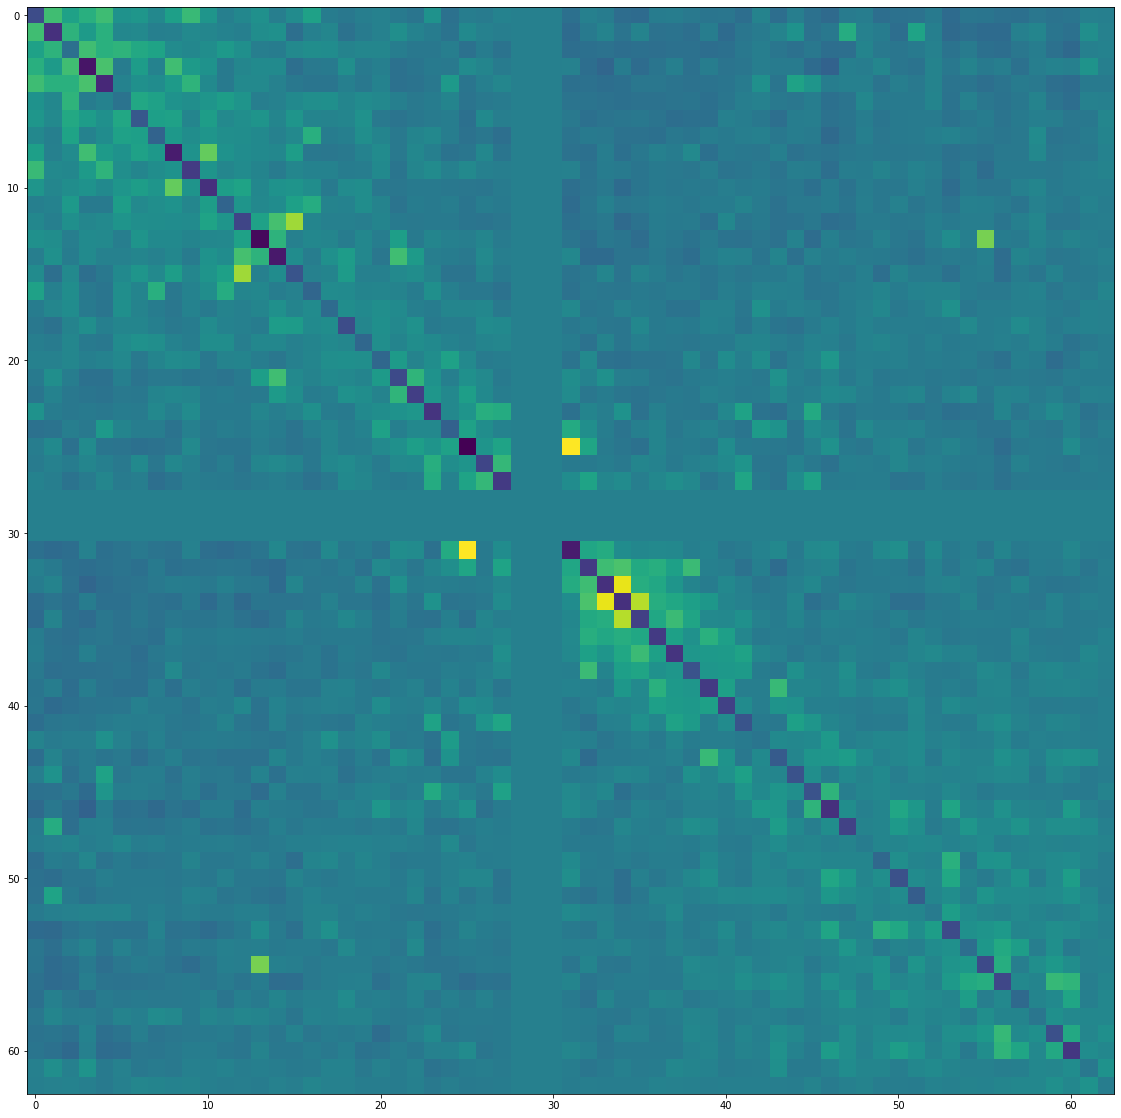

In [15]:
plt.imshow(Sapc)

## Generate sequences

In [16]:
p0=x[:,cumwidth[0]:cumwidth[1]].mean(axis=0)
P0=np.broadcast_to(p0,(Ngen,p0.shape[0]))
A0=tfd.OneHotCategorical(probs=P0).sample()
s=generator.predict(A0)
ss=decodeSequences(s,list("-ACDEFGHIKLMNPQRSTVWY"))

## Performance: frequencies

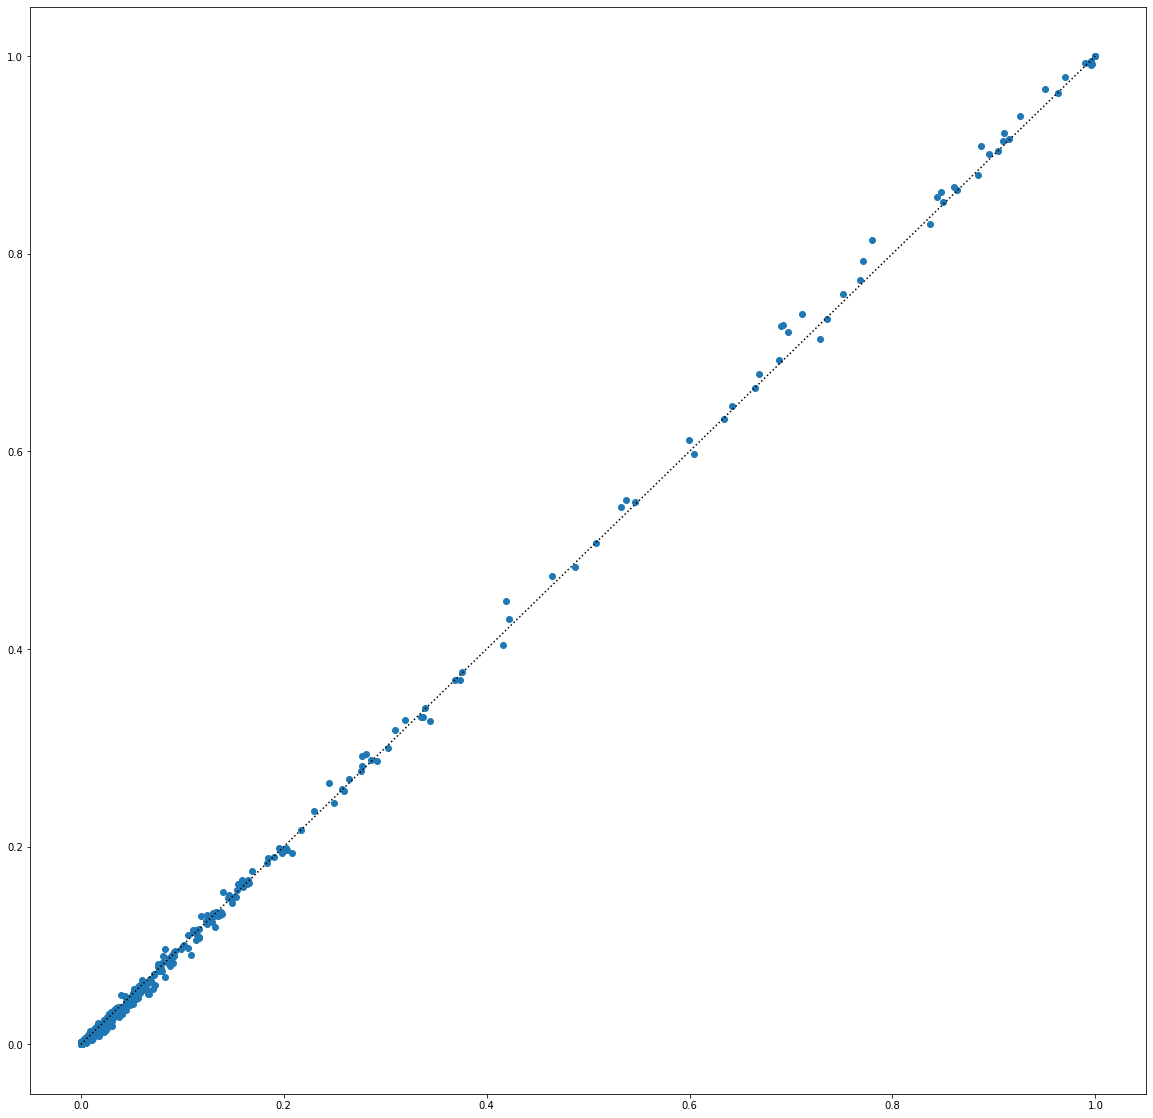

In [17]:
px=x.mean(axis=0)
pg=s.mean(axis=0)
plt.scatter(px,pg)
plt.plot([np.min(px),np.max(px)],[np.min(px),np.max(px)],c='black',linestyle=':')

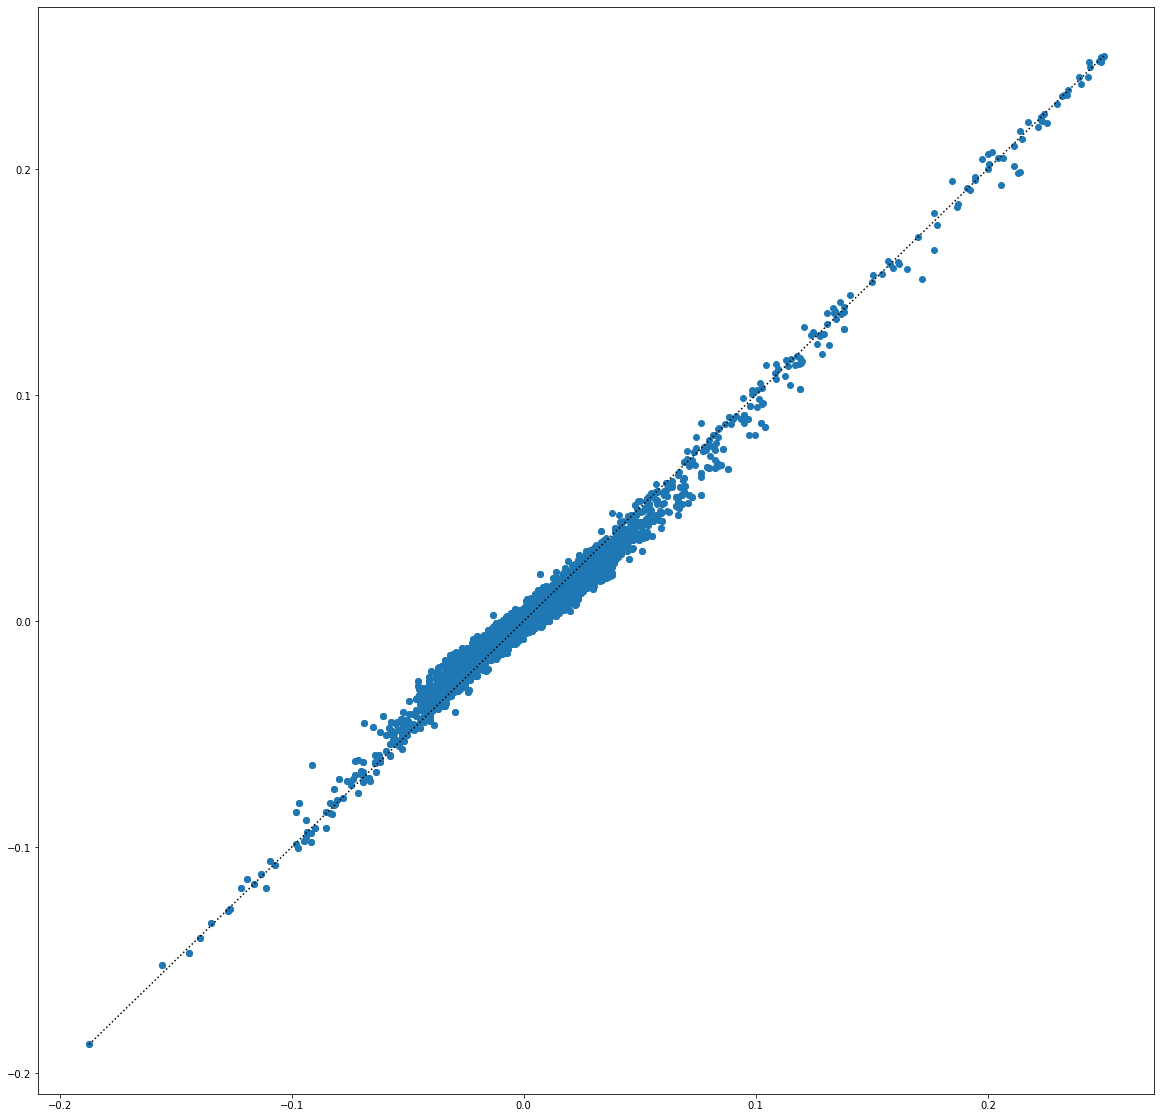

In [18]:
ppx=(np.matmul(x.T,x)/x.shape[0]-np.multiply(px[np.newaxis,:],px[:,np.newaxis])).flatten()
ppg=(np.matmul(s.T,s)/s.shape[0]-np.multiply(pg[np.newaxis,:],pg[:,np.newaxis])).flatten()
plt.scatter(ppx,ppg)
plt.plot([np.min(ppx),np.max(ppx)],[np.min(ppx),np.max(ppx)],c='black',linestyle=':')

## Performance: PCA

In [19]:
pca = PCA(n_components=2)
pca.fit(x)

PCA(n_components=2)

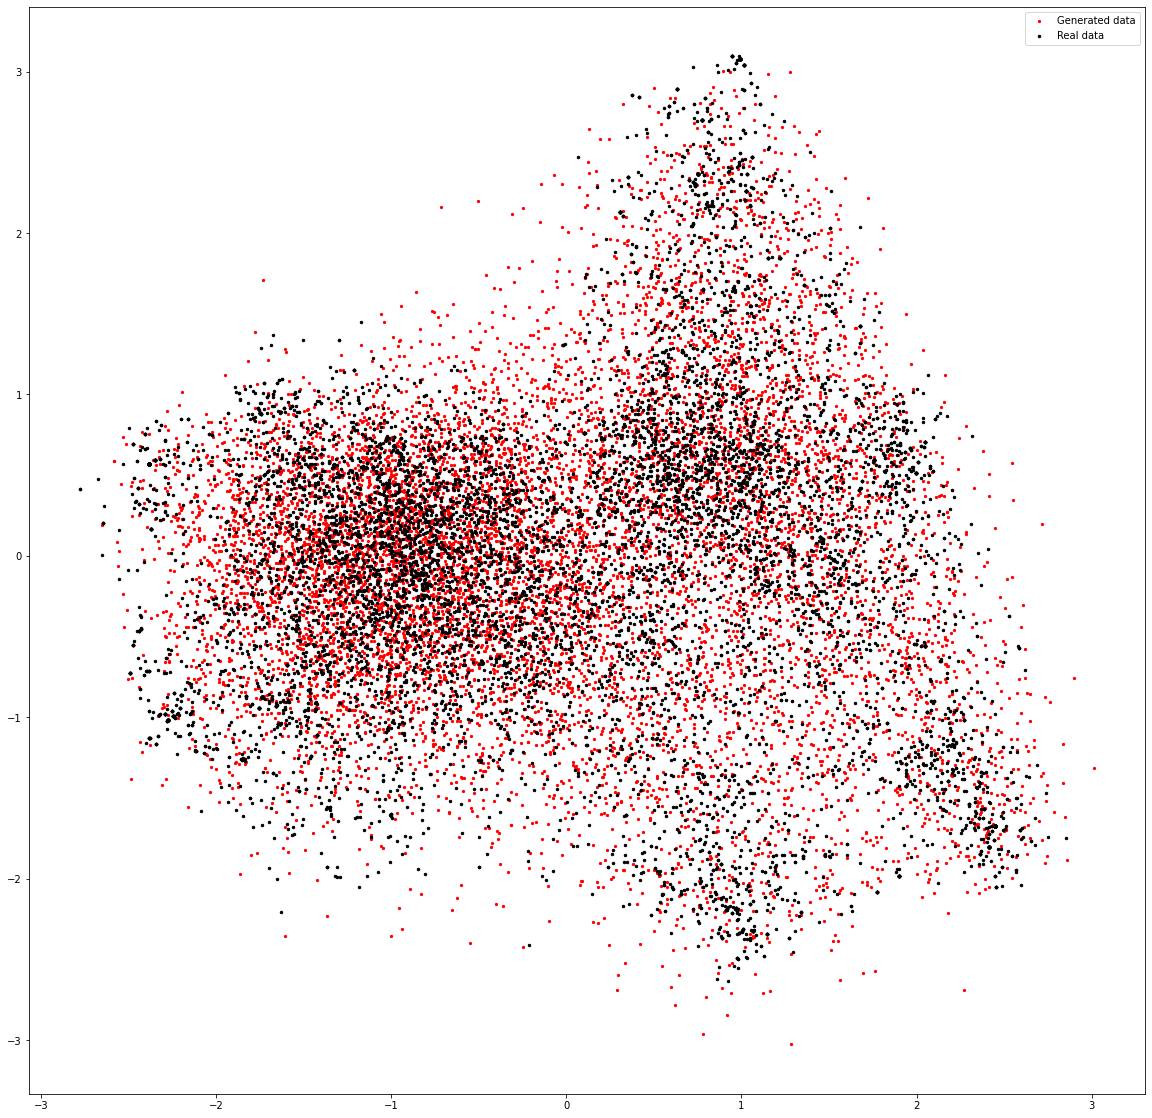

In [20]:
xpca=pca.transform(x)
gpca=pca.transform(s)
if comparetodata is not None:
    xcpca=pca.transform(xc)

plt.scatter(gpca[:,0],gpca[:,1], s=5, c='red', label='Generated data')
if comparetodata is not None:
    plt.scatter(xcpca[:,0],xcpca[:,1], c='green',label='Other method')
plt.scatter(xpca[:,0],xpca[:,1], s=6, c='black',label='Real data')
plt.legend()

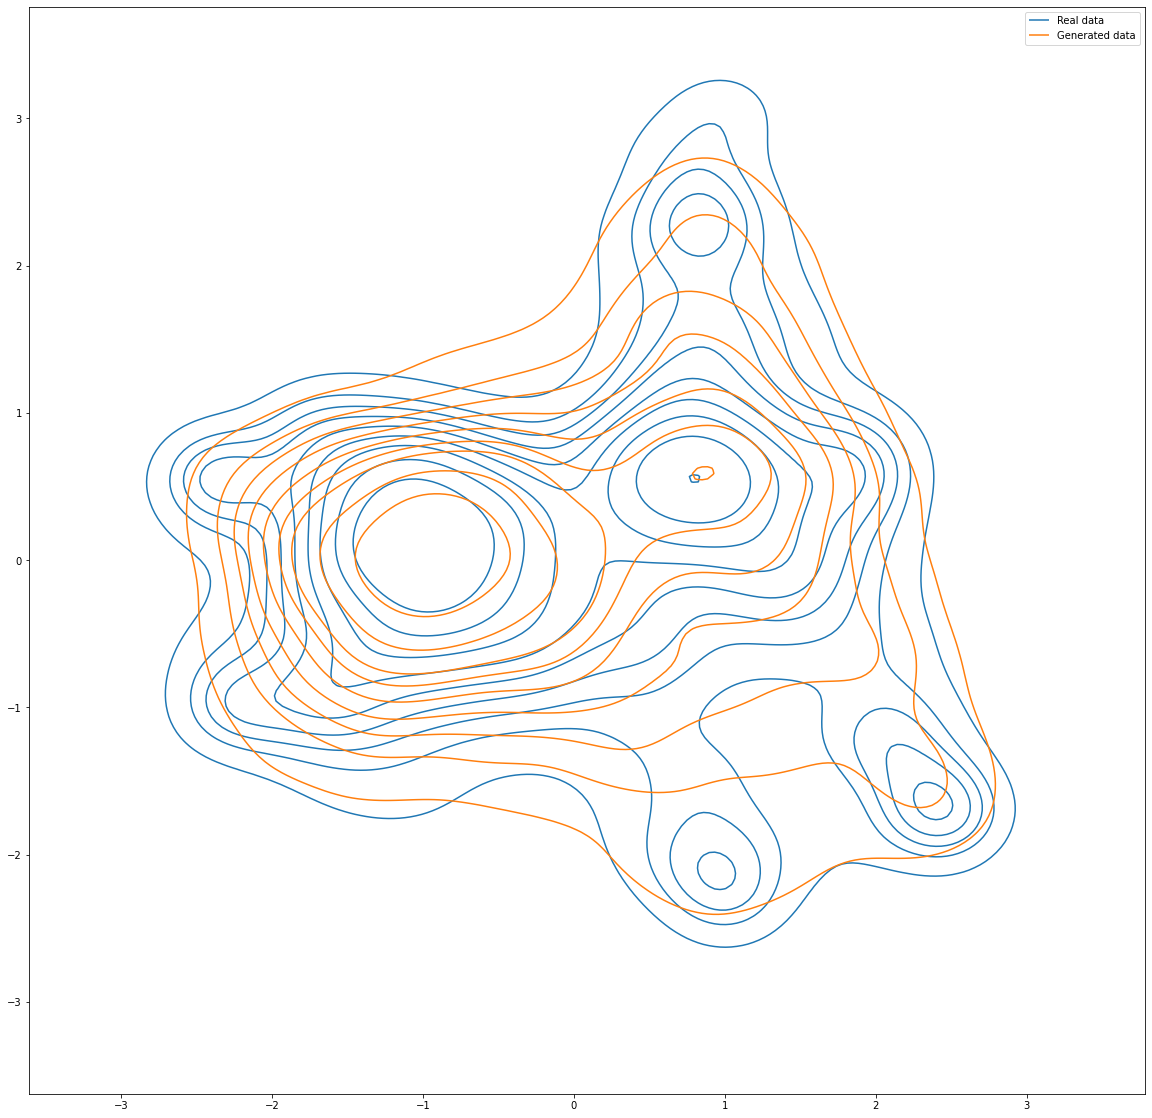

In [21]:
sns.kdeplot(x=xpca[:,0], y=xpca[:,1], levels=10, bw_adjust=1, label='Real data')
sns.kdeplot(x=gpca[:,0], y=gpca[:,1], levels=10, bw_adjust=1, label='Generated data')
plt.legend()

## Performance: UMAP

In [22]:
proj = UMAP()
proj.fit(np.vstack([x,s]))

UMAP(dens_frac=0.0, dens_lambda=0.0)

/home/szamuner/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


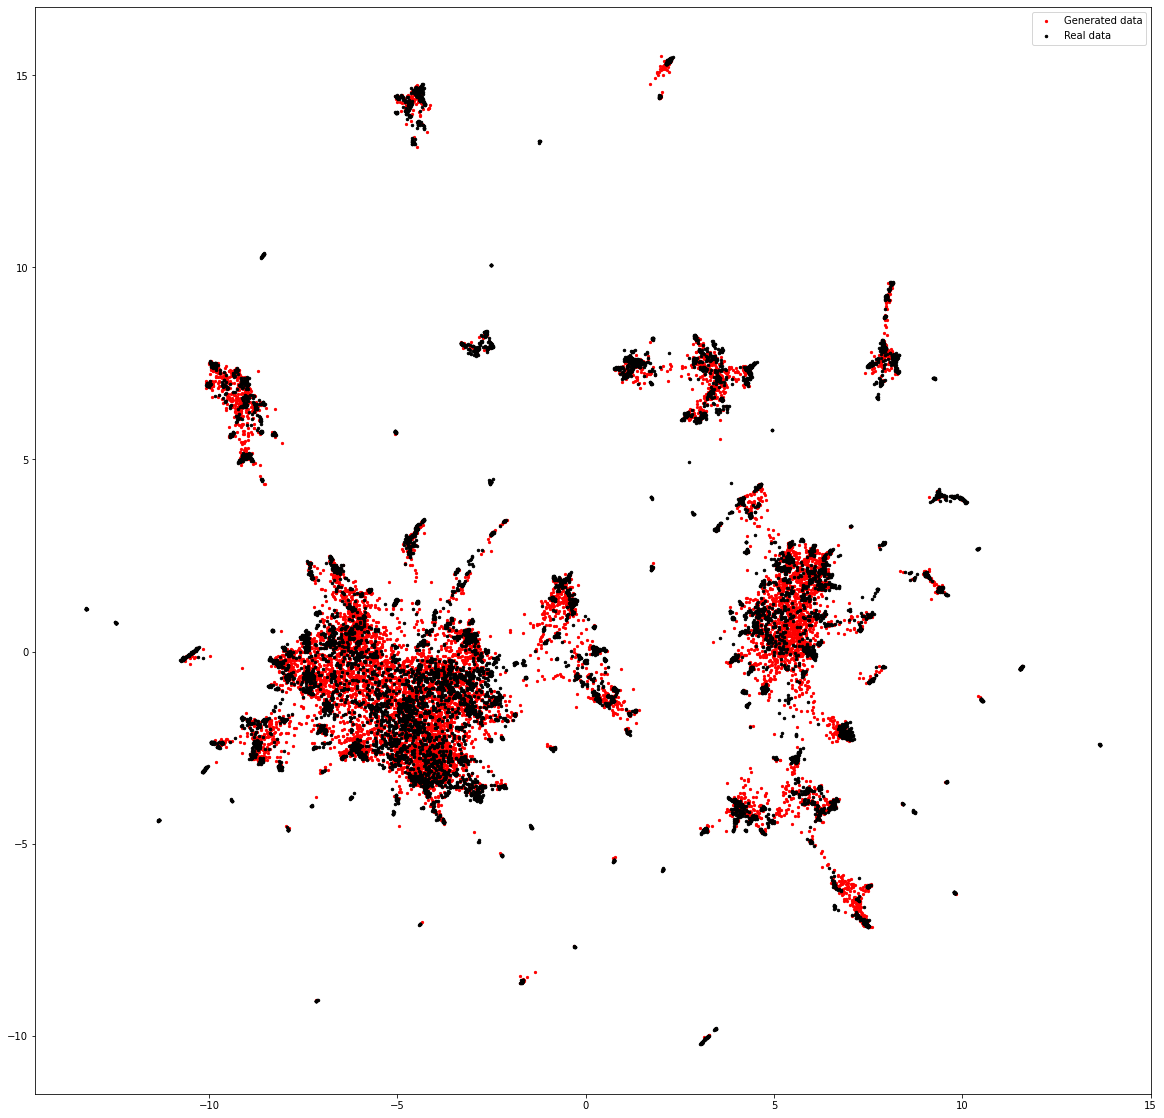

In [23]:
xumap=proj.transform(x)
gumap=proj.transform(s)
if comparetodata is not None:
    xcumap=proj.transform(xc)

plt.scatter(gumap[:,0],gumap[:,1], s=5, c='red', label='Generated data')
if comparetodata is not None:
    plt.scatter(xcumap[:,0],xcumap[:,1], c='green',label='Other method')
plt.scatter(xumap[:,0],xumap[:,1], s=6, c='black',label='Real data')
plt.legend()

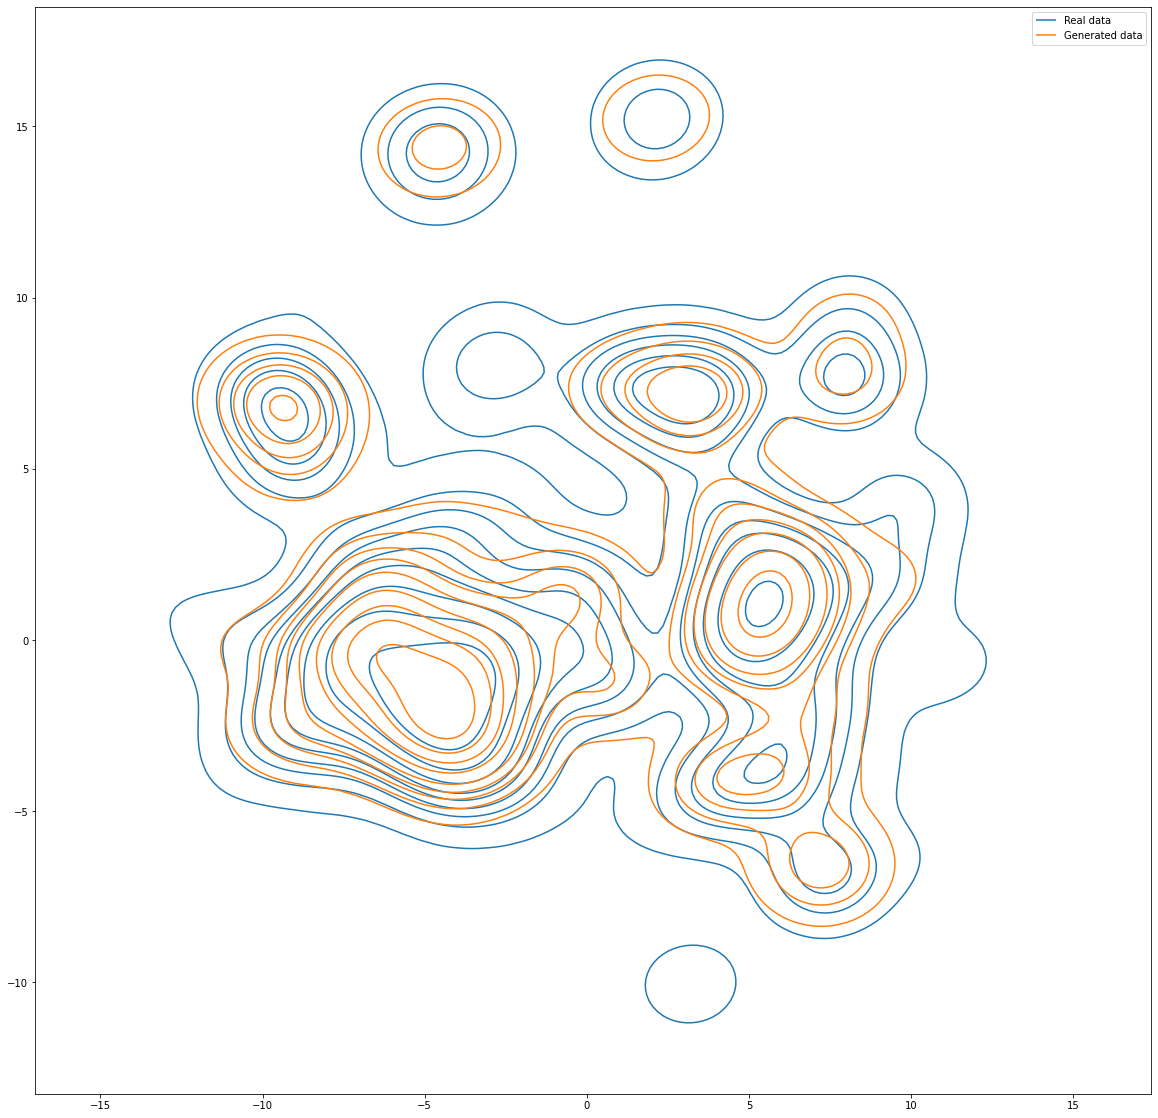

In [24]:
sns.kdeplot(x=xumap[:,0], y=xumap[:,1], levels=10, bw_adjust=1, label='Real data')
sns.kdeplot(x=gumap[:,0], y=gumap[:,1], levels=10, bw_adjust=1, label='Generated data')
plt.legend()